In [30]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc_ext as pmx

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# test LogNormal

In [3]:
def plot_cont(self, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    samples = self.random(size=1000)
    x = np.linspace(np.min(samples), np.max(samples), 1000)
    ax.plot(x, np.exp(self.logp(x)).eval())
    return ax

# Assign this distribution to the abstract class Continuous
pm.Continuous.plot = plot_cont

In [4]:
pm.Normal.dist(mu=-2.6, sigma=1)

normal_rv{0, (0, 0), floatX, False}.out

In [40]:
with pm.Model() as model:
    a, b = pmx.unit_disk(name_x='x', name_y='y')

In [41]:
model

            x ~ Uniform(-1, 1)
__y_unit_disk ~ Uniform(-1, 1)
            y ~ Deterministic(f(__y_unit_disk, x))
 __y_jacobian ~ Potential(f(x))

In [25]:
with pm.Model() as model:
    log_normal = pm.LogNormal("log_ror", mu=np.log(4.052037), sigma=4e-06/4.052037)

In [28]:
with model:
    trace = pm.sample(
        tune=100, #2500,
        draws=100, #2000,
        chains=1, #4
        return_inferencedata=True,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [log_ror]


Output()

Sampling 1 chain for 100 tune and 100 draw iterations (100 + 100 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


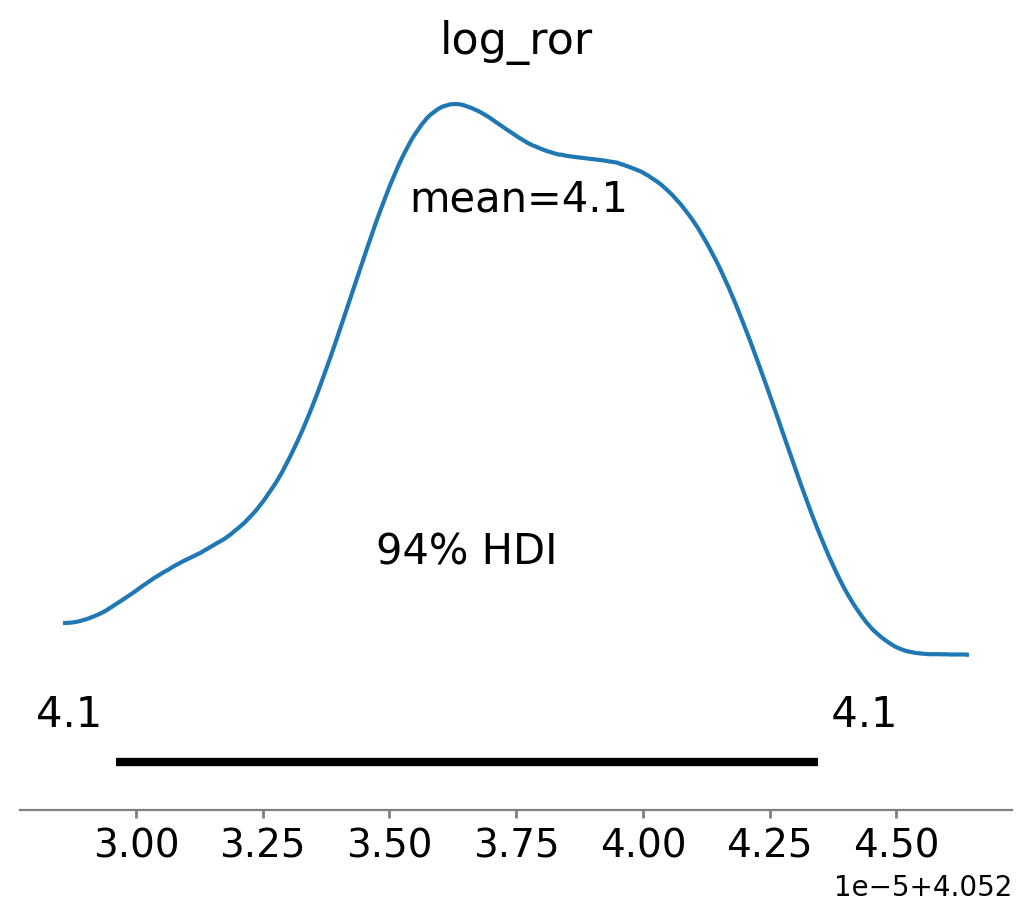

In [29]:
ax = az.plot_posterior(trace)

# test GP

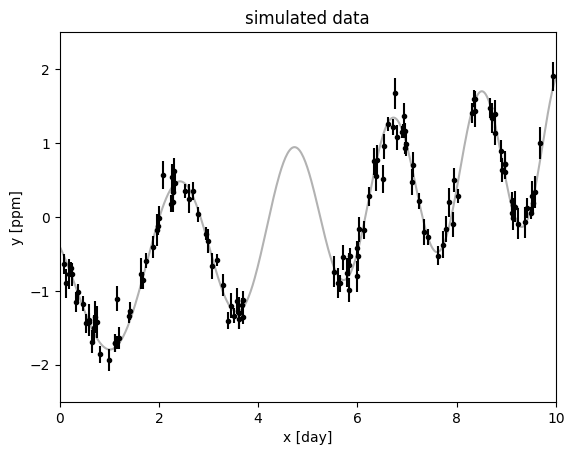

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

t = np.sort(
    np.append(
        np.random.uniform(0, 3.8, 57),
        np.random.uniform(5.5, 10, 68),
    )
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)

true_t = np.linspace(0, 10, 500)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

In [3]:
import pymc as pm
from celerite2.pymc import GaussianProcess, terms as pm_terms
freq = np.linspace(1.0 / 8, 1.0 / 0.3, 500)
omega = 2 * np.pi * freq
prior_sigma = 2.0

with pm.Model() as model:
    mean = pm.Normal("mean", mu=0.0, sigma=prior_sigma)
    log_jitter = pm.Normal("log_jitter", mu=0.0, sigma=prior_sigma)

    log_sigma1 = pm.Normal("log_sigma1", mu=0.0, sigma=prior_sigma)
    log_rho1 = pm.Normal("log_rho1", mu=0.0, sigma=prior_sigma)
    log_tau = pm.Normal("log_tau", mu=0.0, sigma=prior_sigma)
    term1 = pm_terms.SHOTerm(
        sigma=pm.math.exp(log_sigma1),
        rho=pm.math.exp(log_rho1),
        tau=pm.math.exp(log_tau),
    )

    log_sigma2 = pm.Normal("log_sigma2", mu=0.0, sigma=prior_sigma)
    log_rho2 = pm.Normal("log_rho2", mu=0.0, sigma=prior_sigma)
    term2 = pm_terms.SHOTerm(
        sigma=pm.math.exp(log_sigma2), rho=pm.math.exp(log_rho2), Q=0.25
    )

    kernel = term1 + term2
    gp = GaussianProcess(kernel, mean=mean)
    gp.compute(t, diag=yerr**2 + pm.math.exp(log_jitter), quiet=True)
    gp.marginal("obs", observed=y)

    pm.Deterministic("psd", kernel.get_psd(omega))

    trace = pm.sample(
        tune=100,
        draws=100,
        target_accept=0.9,
        init="adapt_full",
        cores=2,
        chains=1,
        random_seed=34923,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:627: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sequential sampling (1 chains in 1 job)
NUTS: [mean, log_jitter, log_sigma1, log_rho1, log_tau, log_sigma2, log_rho2]


Output()

Sampling 1 chain for 100 tune and 100 draw iterations (100 + 100 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
